In [2]:
from google.colab import drive #for uploading the file to collab
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip "/content/drive/MyDrive/Pneumonia Project Folder/chest_xray.zip" -d chest_xray


Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/chest_xray/__MACOSX/chest_xray/train/NORMAL/._IM-0439-0001.jpeg  
  inflating: chest_xray/chest_xray/__MACOSX/chest_xray/train/NORMAL/._IM-0440-0001.jpeg  
  inflating: chest_xray/chest_xray/__MACOSX/chest_xray/train/NORMAL/._IM-0441-0001.jpeg  
  inflating: chest_xray/chest_xray/__MACOSX/chest_xray/train/NORMAL/._IM-0442-0001.jpeg  
  inflating: chest_xray/chest_xray/__MACOSX/chest_xray/train/NORMAL/._IM-0444-0001.jpeg  
  inflating: chest_xray/chest_xray/__MACOSX/chest_xray/train/NORMAL/._IM-0445-0001.jpeg  
  inflating: chest_xray/chest_xray/__MACOSX/chest_xray/train/NORMAL/._IM-0446-0001.jpeg  
  inflating: chest_xray/chest_xray/__MACOSX/chest_xray/train/NORMAL/._IM-0447-0001.jpeg  
  inflating: chest_xray/chest_xray/__MACOSX/chest_xray/train/NORMAL/._IM-0448-0001.jpeg  
  inflating: chest_xray/chest_xray/__MACOSX/chest_xray/train/NORMAL/._IM-0449-0001.jpeg  
  inflating: chest_xray/chest_xray/__MACOSX/chest

In [4]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.model_selection import KFold
import torch

transform = transforms.Compose([
    transforms.Grayscale(), #compression 3 rgb matrix into one for runtime
    transforms.Resize((224, 224)), # can downsample here for runtime
    transforms.ToTensor(),
])
#Loading train, test, and val datasets.
train_dataset = datasets.ImageFolder("chest_xray/chest_xray/train", transform=transform)
test_dataset = datasets.ImageFolder("chest_xray/chest_xray/test", transform=transform)
val_dataset = datasets.ImageFolder("chest_xray/chest_xray/val", transform=transform)


#dataloaders w 32 images each for batches
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
print(train_dataset.classes) # classes for the data (train)





['NORMAL', 'PNEUMONIA']


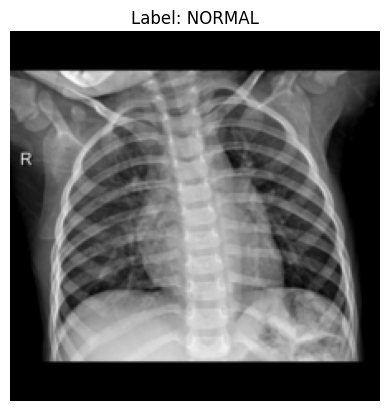

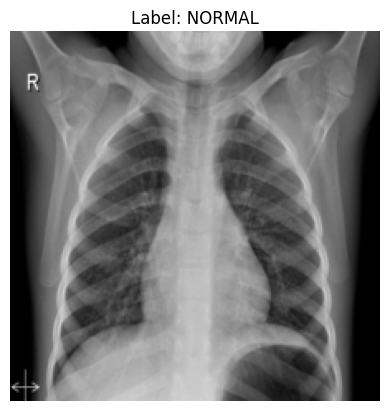

In [14]:
import matplotlib.pyplot as plt
import numpy as np

#image batch
dataiter = iter(train_loader)
images, labels = next(dataiter) #image, label pair


img_ten = images[0] #getting the 0th image/label pair
label = labels[0]

#tensor to NumPy (tensors no work for plotting :P)
img_np = img_ten.numpy()
img_np = np.transpose(img_np, (1, 2, 0))  #NOTE that the height/width need to be reordered when converting

#Image plot with the label on the top (thanks Chodrow!!!)
plt.imshow(img_np, cmap='gray')
plt.title(f"Label: {train_dataset.classes[label]}")
plt.axis("off")
plt.show()

i=13
pnu_img_ten = images[i]

pnu_label = labels[i]

pnu_img_np = pnu_img_ten.numpy()
pnu_img_np = np.transpose(pnu_img_np, (1, 2, 0))

plt.imshow(pnu_img_np, cmap='gray')
plt.title(f"Label: {train_dataset.classes[pnu_label]}")
plt.axis('off')
plt.show()


In [5]:
#Image Dimension (for later)

pnu_img_ten.size()

torch.Size([1, 224, 224])

In [5]:
## auto encoder
import torch
import torch.nn as nn
import torch.optim as optim
"""
B = batch size (32)

C = channels (1)

H = heightv (224)

W = width (224) """

# Autoencoder
class PneumoniaAutoencoder(nn.Module):
    def __init__(self):
        super(PneumoniaAutoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),  # [B, 16, 112, 112]
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), # [B, 32, 56, 56]
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1), # [B, 64, 28, 28]
            nn.ReLU(),
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1), # [B, 32, 56, 56]
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1), # [B, 16, 112, 112]
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),  # [B, 1, 224, 224]
            nn.Sigmoid(),
        )

    def forward(self, x):
        latent = self.encoder(x)
        reconstructed = self.decoder(latent)
        return reconstructed


In [7]:
## training

# Instantiate model, loss, optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") #easy to switch between cpu and gpu
model = PneumoniaAutoencoder().to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)



In [6]:
from tqdm import tqdm

num_epochs = 1

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    # progress bar (really nice)
    pbar = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}]")

    for images, _ in pbar:
        images = images.to(device)

        outputs = model(images)
        loss = criterion(outputs, images)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Update bar
        pbar.set_postfix({'loss': loss.item()})

    avg_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Avg Loss: {avg_loss:.4f}")

NameError: name 'model' is not defined

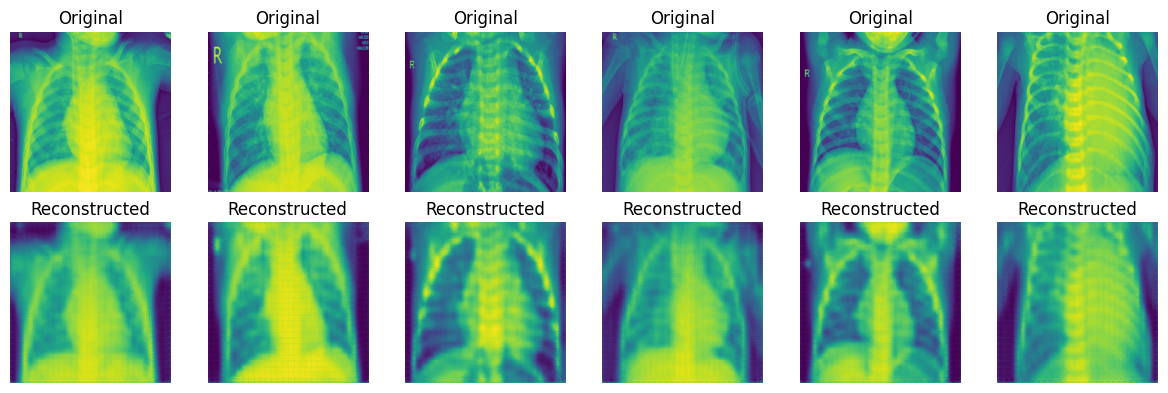

In [9]:
## reconstructed images

import matplotlib.pyplot as plt
import numpy as np

# eval
model.eval()

# batch
dataiter = iter(train_loader)
images, _ = next(dataiter)
images = images.to(device)

# Reconstruct images
with torch.no_grad():
    reconstructions = model(images)

# Move tensors to CPU for plotting (np can't use gpu)
images = images.cpu()
reconstructions = reconstructions.cpu()

#transpose for tensor --> numpy
def tensor_to_img(t):
    t = t.numpy()
    t = np.transpose(t, (1, 2, 0))
    return t

# Plot original and reconstructed
n = 6 #num images
plt.figure(figsize=(12, 4))
for i in range(n):
    # Original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(tensor_to_img(images[i]))
    ax.set_title("Original")
    plt.axis("off")

    # Reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(tensor_to_img(reconstructions[i]))
    ax.set_title("Reconstructed")
    plt.axis("off")

plt.tight_layout()
plt.show()


## PCA plot to understand if differences encoded are meaningful

In [ ]:
model.eval()
latent_vectors = []
labels_list = []

with torch.no_grad():
    for images, labels in train_loader:  # labels: 0=norm, 1=pneu
        images = images.to(device)
        encoded = model.encoder(images)
        # Flatten
        encoded = encoded.view(encoded.size(0), -1).cpu().numpy()
        latent_vectors.append(encoded)
        labels_list.append(labels.cpu().numpy())

# Stack into arrays
import numpy as np
X = np.vstack(latent_vectors)
y = np.hstack(labels_list)

from sklearn.decomposition import PCA

pca = PCA(n_components=2) #2 Principal components
X_pca = pca.fit_transform(X)


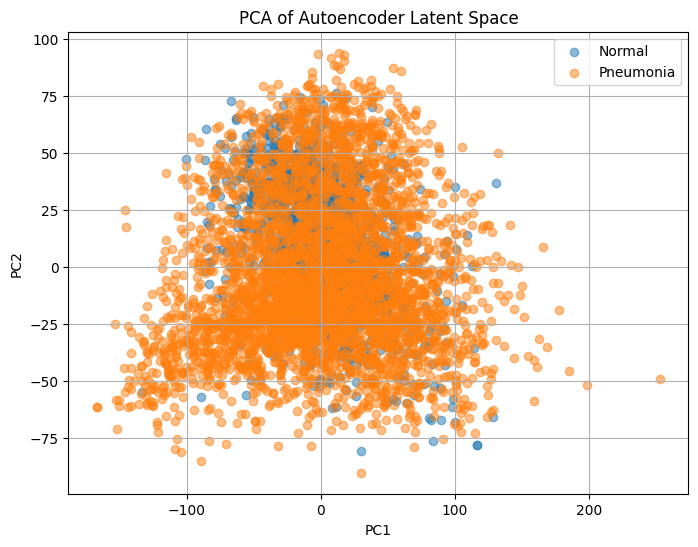

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[y==0, 0], X_pca[y==0, 1], label="Normal", alpha=0.5)
plt.scatter(X_pca[y==1, 0], X_pca[y==1, 1], label="Pneumonia", alpha=0.5)
plt.title("PCA of Autoencoder Latent Space")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.grid(True)
plt.show()


## Contrastive Loss

In [ ]:
class ContrastiveEncoder(nn.Module):
    def __init__(self, latent_dim=64):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 4, 2, 1),  #didn't spend too much time here since it didn't do great.
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2, 1),
            nn.ReLU(),
            nn.Flatten()
        )
        self.flattened_size = 64 * 56 * 56
        self.fc_mu = nn.Linear(self.flattened_size, latent_dim)

    def forward(self, x):
        x = self.encoder(x)
        mu = self.fc_mu(x)
        return mu


In [ ]:
def train_encoder(model, dataloader, optimizer, device, epochs=10):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for x, y in tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}"):
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            mu = model(x)
            loss = supervised_contrastive_loss(mu, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1} - Contrastive Loss: {total_loss / len(dataloader):.4f}")


In [ ]:
import plotly.express as px

def plot_latent_space_3d(model, dataloader, device):
    model.eval()
    mus = []
    labels = []

    with torch.no_grad():
        for x, y in dataloader:
            x = x.to(device)
            mu = model(x)
            mus.append(mu.cpu().numpy())
            labels.append(y.numpy())

    mus = np.concatenate(mus, axis=0)
    labels = np.concatenate(labels, axis=0)

    # PCA
    pca = PCA(n_components=3)
    reduced = pca.fit_transform(mus)

    # pd.data.frame for plotly!
    import pandas as pd
    df = pd.DataFrame({
        'PC1': reduced[:, 0],
        'PC2': reduced[:, 1],
        'PC3': reduced[:, 2],
        'Label': labels
    })

    fig = px.scatter_3d(df, x='PC1', y='PC2', z='PC3',
                        color=df['Label'].astype(str),
                        title='3D PCA of Latent Space',
                        labels={'color': 'Class'},
                        opacity=0.7)
    fig.update_traces(marker=dict(size=4))
    fig.show()


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ContrastiveEncoder(latent_dim=64).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

train_encoder(
    model,
    train_loader,
    optimizer,
    device,
    epochs=10)


Epoch 1/10: 100%|██████████| 163/163 [01:11<00:00,  2.27it/s]


Epoch 1 - Contrastive Loss: 10229413499.0815


Epoch 2/10: 100%|██████████| 163/163 [01:10<00:00,  2.31it/s]


Epoch 2 - Contrastive Loss: 5984462881873.6689


Epoch 3/10: 100%|██████████| 163/163 [01:10<00:00,  2.31it/s]


Epoch 3 - Contrastive Loss: 165640260111605.0000


Epoch 4/10: 100%|██████████| 163/163 [01:11<00:00,  2.28it/s]


Epoch 4 - Contrastive Loss: 1046564519824227.0000


Epoch 5/10: 100%|██████████| 163/163 [01:10<00:00,  2.30it/s]


Epoch 5 - Contrastive Loss: 4228928954451226.5000


Epoch 6/10: 100%|██████████| 163/163 [01:09<00:00,  2.33it/s]


Epoch 6 - Contrastive Loss: 9165964179117364.0000


Epoch 7/10: 100%|██████████| 163/163 [01:07<00:00,  2.40it/s]


Epoch 7 - Contrastive Loss: 41170843080356120.0000


Epoch 8/10: 100%|██████████| 163/163 [01:10<00:00,  2.33it/s]


Epoch 8 - Contrastive Loss: 62285426339613840.0000


Epoch 9/10: 100%|██████████| 163/163 [01:08<00:00,  2.38it/s]


Epoch 9 - Contrastive Loss: 210256527717879648.0000


Epoch 10/10: 100%|██████████| 163/163 [01:09<00:00,  2.33it/s]

Epoch 10 - Contrastive Loss: 280468405382119232.0000


In [ ]:
plot_latent_space_3d(model, train_loader, device)

## Variational AutoEncoder with Contrastive loss

In [35]:
from tqdm import tqdm
import torch
import torch.nn as nn
import numpy as np
from sklearn.decomposition import PCA
#variational autoencoder w contrastive learning :)
class ContrastiveVAE(nn.Module):
    def __init__(self, latent_dim=64):
        super(ContrastiveVAE, self).__init__()
        self.latent_dim = latent_dim

        # Encoder CNN
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(1, 32, 4, 2, 1),  # (B, 32, 112, 112)
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2, 1), # (B, 64, 56, 56)
            nn.ReLU(),
        )

        self.flattened_size = 64 * 56 * 56
        self.encoder_flatten = nn.Flatten()
        self.fc_mu = nn.Linear(self.flattened_size, latent_dim)
        self.fc_logvar = nn.Linear(self.flattened_size, latent_dim)

        # Decoder (not really using had from before)
        self.decoder_input = nn.Linear(latent_dim, self.flattened_size)
        self.decoder = nn.Sequential(
            nn.Unflatten(1, (64, 56, 56)),
            nn.ConvTranspose2d(64, 32, 4, 2, 1),  # (B, 32, 112, 112)
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 4, 2, 1),   # (B, 1, 224, 224)
            nn.Sigmoid()
        )

    def encode(self, x):
        x = self.encoder_cnn(x)
        x = self.encoder_flatten(x)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        x = self.decoder_input(z)
        x = self.decoder(x)
        return x

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z)
        return x_recon, mu, logvar



In [36]:
def supervised_contrastive_loss(embeddings, labels, temperature=0.1):
  #contrastive loss function for VAE

    device = embeddings.device
    labels = labels.contiguous().view(-1, 1)
    mask = torch.eq(labels, labels.T).float().to(device)

    dot_product = (embeddings @ embeddings.T) / temperature
    logits_max, _ = torch.max(dot_product, dim=1, keepdim=True)
    logits = dot_product - logits_max.detach()

    exp_logits = torch.exp(logits) * (1 - torch.eye(len(labels), device=device))
    log_prob = logits - torch.log(exp_logits.sum(1, keepdim=True) + 1e-8)

    mean_log_prob_pos = (mask * log_prob).sum(1) / mask.sum(1)
    loss = -mean_log_prob_pos.mean()
    return loss


In [37]:
def get_balanced_indices(labels):
    """Returns an equal number of positive and negative indices."""
    pos_indices = [i for i, y in enumerate(labels) if y == 1]
    neg_indices = [i for i, y in enumerate(labels) if y == 0]

    min_class_len = min(len(pos_indices), len(neg_indices))
    pos_sample = np.random.choice(pos_indices, min_class_len, replace=False)
    neg_sample = np.random.choice(neg_indices, min_class_len, replace=False)

    return np.concatenate([pos_sample, neg_sample])

In [47]:
from torch.utils.data import DataLoader, SubsetRandomSampler
from sklearn.model_selection import KFold
import numpy as np
from collections import defaultdict


def train_vae(model_class, dataset, optimizer_class, device, epochs=10, beta=1.0, contrastive_weight=1.0):
    recon_loss_fn = nn.MSELoss(reduction='sum')
    k_folds = 5
    batch_size = 32
    kf = KFold(n_splits=k_folds, shuffle=True)

    all_labels = [label for _, label in dataset]
    fold_results = []

    for fold, (train_idx, test_idx) in enumerate(kf.split(dataset)):
        print(f"\nFold {fold + 1}")
        print("-------")

        #Balanced sampling
        train_labels = [all_labels[i] for i in train_idx]
        balanced_indices = get_balanced_indices(train_labels)
        balanced_train_idx = [train_idx[i] for i in balanced_indices]

        #Loaders
        train_loader = DataLoader(
            dataset,
            batch_size=batch_size,
            sampler=SubsetRandomSampler(balanced_train_idx),
        )
        test_loader = DataLoader(
            dataset,
            batch_size=batch_size,
            sampler=SubsetRandomSampler(test_idx),
        )

        #model and optimizer
        model = model_class().to(device)
        optimizer = optimizer_class(model.parameters())

        for epoch in range(epochs):
            model.train()
            total_loss = 0

            for x, y in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
                x, y = x.to(device), y.to(device)
                optimizer.zero_grad()

                x_recon, mu, logvar = model(x)
                recon_loss = recon_loss_fn(x_recon, x) / x.size(0)
                kl_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
                contrastive = supervised_contrastive_loss(mu, y)

                loss = recon_loss + beta * kl_loss + contrastive_weight * contrastive
                loss.backward()
                optimizer.step()

                total_loss += loss.item()

            print(f"Epoch {epoch+1} - Train Loss: {total_loss / len(train_loader):.4f}")

        #test set evaluation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for x, y in test_loader:
                x, y = x.to(device), y.to(device)
                x_recon, mu, logvar = model(x)
                recon_loss = recon_loss_fn(x_recon, x) / x.size(0)
                kl_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
                contrastive = supervised_contrastive_loss(mu, y)
                loss = recon_loss + beta * kl_loss + contrastive_weight * contrastive
                val_loss += loss.item()

        val_loss /= len(test_loader)
        print(f"Fold {fold + 1} - Validation Loss: {val_loss:.4f}")
        fold_results.append(val_loss)

    print(f"\nAverage Validation Loss: {np.mean(fold_results):.4f} ± {np.std(fold_results):.4f}")
    return model #returning trained model


In [40]:
import plotly.express as px

def plot_latent_space_3d(model, dataloader, device):
    model.eval()
    mus = []
    labels = []

    with torch.no_grad():
        for x, y in dataloader:
            x = x.to(device)
            mu, _ = model.encode(x)
            mus.append(mu.cpu().numpy())
            labels.append(y.numpy())

    mus = np.concatenate(mus, axis=0)
    labels = np.concatenate(labels, axis=0)

    # PCA for visualization
    pca = PCA(n_components=3)
    reduced = pca.fit_transform(mus)

    # Create pd.data.frame for Plotly
    import pandas as pd
    df = pd.DataFrame({
        'PC1': reduced[:, 0],
        'PC2': reduced[:, 1],
        'PC3': reduced[:, 2],
        'Label': labels
    })

    fig = px.scatter_3d(df, x='PC1', y='PC2', z='PC3',
                        color=df['Label'].astype(str),
                        title='3D PCA of Latent Space',
                        labels={'color': 'Class'},
                        opacity=0.7)
    fig.update_traces(marker=dict(size=4))
    fig.show()


In [48]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = train_vae(
    model_class=lambda: ContrastiveVAE(latent_dim=64),
    dataset=train_dataset,
    optimizer_class=lambda params: torch.optim.Adam(params, lr=1e-3),
    device=device,
    epochs=10,
    beta=1.0,
    contrastive_weight=5.0
)



Fold 1
-------


Epoch 1/10: 100%|██████████| 66/66 [00:40<00:00,  1.61it/s]


Epoch 1 - Train Loss: 1732.5170


Epoch 2/10: 100%|██████████| 66/66 [00:40<00:00,  1.62it/s]


Epoch 2 - Train Loss: 955.7409


Epoch 3/10: 100%|██████████| 66/66 [00:40<00:00,  1.62it/s]


Epoch 3 - Train Loss: 913.7289


Epoch 4/10: 100%|██████████| 66/66 [00:39<00:00,  1.66it/s]


Epoch 4 - Train Loss: 829.5965


Epoch 5/10: 100%|██████████| 66/66 [00:39<00:00,  1.66it/s]


Epoch 5 - Train Loss: 669.1735


Epoch 6/10: 100%|██████████| 66/66 [00:39<00:00,  1.66it/s]


Epoch 6 - Train Loss: 546.1503


Epoch 7/10: 100%|██████████| 66/66 [00:39<00:00,  1.66it/s]


Epoch 7 - Train Loss: 486.2967


Epoch 8/10: 100%|██████████| 66/66 [00:39<00:00,  1.67it/s]


Epoch 8 - Train Loss: 448.7016


Epoch 9/10: 100%|██████████| 66/66 [00:39<00:00,  1.67it/s]


Epoch 9 - Train Loss: 422.6283


Epoch 10/10: 100%|██████████| 66/66 [00:39<00:00,  1.66it/s]


Epoch 10 - Train Loss: 403.2279
Fold 1 - Validation Loss: 414.3516

Fold 2
-------


Epoch 1/10: 100%|██████████| 67/67 [00:40<00:00,  1.66it/s]


Epoch 1 - Train Loss: 1741.7729


Epoch 2/10: 100%|██████████| 67/67 [00:41<00:00,  1.61it/s]


Epoch 2 - Train Loss: 948.6682


Epoch 3/10: 100%|██████████| 67/67 [00:40<00:00,  1.67it/s]


Epoch 3 - Train Loss: 927.1798


Epoch 4/10: 100%|██████████| 67/67 [00:40<00:00,  1.66it/s]


Epoch 4 - Train Loss: 862.6751


Epoch 5/10: 100%|██████████| 67/67 [00:40<00:00,  1.65it/s]


Epoch 5 - Train Loss: 735.6842


Epoch 6/10: 100%|██████████| 67/67 [00:40<00:00,  1.65it/s]


Epoch 6 - Train Loss: 582.4736


Epoch 7/10: 100%|██████████| 67/67 [00:41<00:00,  1.63it/s]


Epoch 7 - Train Loss: 516.1311


Epoch 8/10: 100%|██████████| 67/67 [00:40<00:00,  1.66it/s]


Epoch 8 - Train Loss: 477.5839


Epoch 9/10: 100%|██████████| 67/67 [00:40<00:00,  1.66it/s]


Epoch 9 - Train Loss: 443.8565


Epoch 10/10: 100%|██████████| 67/67 [00:41<00:00,  1.60it/s]


Epoch 10 - Train Loss: 422.4739
Fold 2 - Validation Loss: 415.2998

Fold 3
-------


Epoch 1/10: 100%|██████████| 68/68 [00:40<00:00,  1.66it/s]


Epoch 1 - Train Loss: 1762.5229


Epoch 2/10: 100%|██████████| 68/68 [00:41<00:00,  1.66it/s]


Epoch 2 - Train Loss: 942.5857


Epoch 3/10: 100%|██████████| 68/68 [00:42<00:00,  1.62it/s]


Epoch 3 - Train Loss: 861.4873


Epoch 4/10: 100%|██████████| 68/68 [00:40<00:00,  1.66it/s]


Epoch 4 - Train Loss: 690.9830


Epoch 5/10: 100%|██████████| 68/68 [00:41<00:00,  1.66it/s]


Epoch 5 - Train Loss: 573.7701


Epoch 6/10: 100%|██████████| 68/68 [00:40<00:00,  1.66it/s]


Epoch 6 - Train Loss: 509.3681


Epoch 7/10: 100%|██████████| 68/68 [00:42<00:00,  1.61it/s]


Epoch 7 - Train Loss: 473.3073


Epoch 8/10: 100%|██████████| 68/68 [00:42<00:00,  1.62it/s]


Epoch 8 - Train Loss: 437.9221


Epoch 9/10: 100%|██████████| 68/68 [00:41<00:00,  1.65it/s]


Epoch 9 - Train Loss: 423.5857


Epoch 10/10: 100%|██████████| 68/68 [00:41<00:00,  1.66it/s]


Epoch 10 - Train Loss: 393.2446
Fold 3 - Validation Loss: 415.2419

Fold 4
-------


Epoch 1/10: 100%|██████████| 70/70 [00:42<00:00,  1.67it/s]


Epoch 1 - Train Loss: 1744.2639


Epoch 2/10: 100%|██████████| 70/70 [00:42<00:00,  1.64it/s]


Epoch 2 - Train Loss: 931.9132


Epoch 3/10: 100%|██████████| 70/70 [00:41<00:00,  1.68it/s]


Epoch 3 - Train Loss: 826.6106


Epoch 4/10: 100%|██████████| 70/70 [00:42<00:00,  1.64it/s]


Epoch 4 - Train Loss: 639.2911


Epoch 5/10: 100%|██████████| 70/70 [00:41<00:00,  1.67it/s]


Epoch 5 - Train Loss: 530.8361


Epoch 6/10: 100%|██████████| 70/70 [00:41<00:00,  1.69it/s]


Epoch 6 - Train Loss: 493.1230


Epoch 7/10: 100%|██████████| 70/70 [00:42<00:00,  1.63it/s]


Epoch 7 - Train Loss: 438.6510


Epoch 8/10: 100%|██████████| 70/70 [00:42<00:00,  1.66it/s]


Epoch 8 - Train Loss: 404.3511


Epoch 9/10: 100%|██████████| 70/70 [00:41<00:00,  1.67it/s]


Epoch 9 - Train Loss: 382.9806


Epoch 10/10: 100%|██████████| 70/70 [00:41<00:00,  1.69it/s]


Epoch 10 - Train Loss: 370.4933
Fold 4 - Validation Loss: 361.8129

Fold 5
-------


Epoch 1/10: 100%|██████████| 68/68 [00:42<00:00,  1.61it/s]


Epoch 1 - Train Loss: 1615.4162


Epoch 2/10: 100%|██████████| 68/68 [00:41<00:00,  1.66it/s]


Epoch 2 - Train Loss: 849.9601


Epoch 3/10: 100%|██████████| 68/68 [00:41<00:00,  1.65it/s]


Epoch 3 - Train Loss: 660.2175


Epoch 4/10: 100%|██████████| 68/68 [00:40<00:00,  1.66it/s]


Epoch 4 - Train Loss: 554.7347


Epoch 5/10: 100%|██████████| 68/68 [00:40<00:00,  1.66it/s]


Epoch 5 - Train Loss: 503.9544


Epoch 6/10: 100%|██████████| 68/68 [00:41<00:00,  1.65it/s]


Epoch 6 - Train Loss: 459.4036


Epoch 7/10: 100%|██████████| 68/68 [00:41<00:00,  1.62it/s]


Epoch 7 - Train Loss: 430.2120


Epoch 8/10: 100%|██████████| 68/68 [00:42<00:00,  1.62it/s]


Epoch 8 - Train Loss: 423.4917


Epoch 9/10: 100%|██████████| 68/68 [00:41<00:00,  1.65it/s]


Epoch 9 - Train Loss: 396.9291


Epoch 10/10: 100%|██████████| 68/68 [00:41<00:00,  1.66it/s]


Epoch 10 - Train Loss: 368.3701
Fold 5 - Validation Loss: 377.8079

Average Validation Loss: 396.9028 ± 22.6943


In [53]:

plot_latent_space_3d(model, test_loader, device)


## Testing on Model to see how well it performs

In [23]:
def extract_latent_vectors(model, dataloader, device):
    model.eval()
    all_mu = []
    all_labels = []

    with torch.no_grad():
        for x, y in dataloader:
            x = x.to(device)
            mu, _ = model.encode(x)
            all_mu.append(mu.cpu().numpy()) #add all into np array
            all_labels.append(y.numpy())

    X = np.concatenate(all_mu, axis=0)
    y = np.concatenate(all_labels, axis=0)
    return X, y


In [50]:
X_train, y_train = extract_latent_vectors(model, train_loader, device)
X_test, y_test = extract_latent_vectors(model, test_loader, device)


In [75]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

model_test = LogisticRegression(max_iter=100, verbose = 1)
model_test.fit(X_train, y_train)

y_pred = model_test.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))}


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning:

[17:34:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.




Accuracy: 0.7865168539325843
              precision    recall  f1-score   support

         0.0     0.8623    0.5107    0.6415       233
         1.0     0.7649    0.9513    0.8480       390

    accuracy                         0.7865       623
   macro avg     0.8136    0.7310    0.7448       623
weighted avg     0.8014    0.7865    0.7708       623



NameError: name 'plt' is not defined

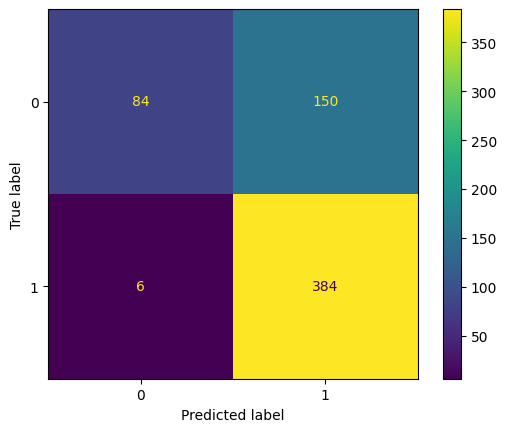

In [26]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(model_test, X_test, y_test)
plt.title("Confusion Matrix for Logistic Regression")
plt.show()
